# Exploring the DRIFT model 

The DRIFT model was proposed by Read, Fredereick, & Scholten (2012). The decision rule (as presented in Ericson et al, 2015) is:

$$
\begin{aligned}
x &= \beta_0 \\
& + \beta_1 \cdot (RB-RA) \\
& + \beta_2 \cdot \frac{RB-RA}{RA} \\
& + \beta_3 \cdot ( \frac{RB}{RA}^{\frac{1}{DB-DA}}-1) \\
& + \beta_4 \cdot (DB-DA) \\
\end{aligned}
$$

where the stochastic choice rule is 

$$
P(choose B | data) = \Phi(x)
$$

where $\Phi()$ is the _standard_ cumulative normal distribution.

In [1]:
# Point Python to the path where we have installed the bad and darc packages
import sys
sys.path.insert(0, '/Users/btvincent/git-local/darc-experiments-python')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import seaborn as sns

import darc
from darc.delayed import models
from darc.designs import BayesianAdaptiveDesignGeneratorDARC, DesignSpaceBuilder
from darc.parameter_recovery import simulated_experiment_trial_loop
from darc.data_plotting import data_plotter

import bad.triplot

# Can the DRIFT model accurately account for hyperbolic discounting behaviour?

## Create a simulated participant who discounts according to the hyperbolic discounting behaviour
Create a true reponse model with given parameters

In [4]:
response_model = models.Hyperbolic(n_particles=10_000)
response_model.θ_true = pd.DataFrame.from_dict({'logk': [-4], 'α': [0.1]})

def hyperbolic_discount_func(delay, logk):
    '''hyperbolic discount function, used for plotting indifference curves'''
    k = np.exp(logk)
    return np.divide(1, (1 + k * delay))

For the sake of clarity, we will run a simulated experiment, fitting a hyperbolic model to this hyperbolic observer. This will allow us to see their behaviour well.

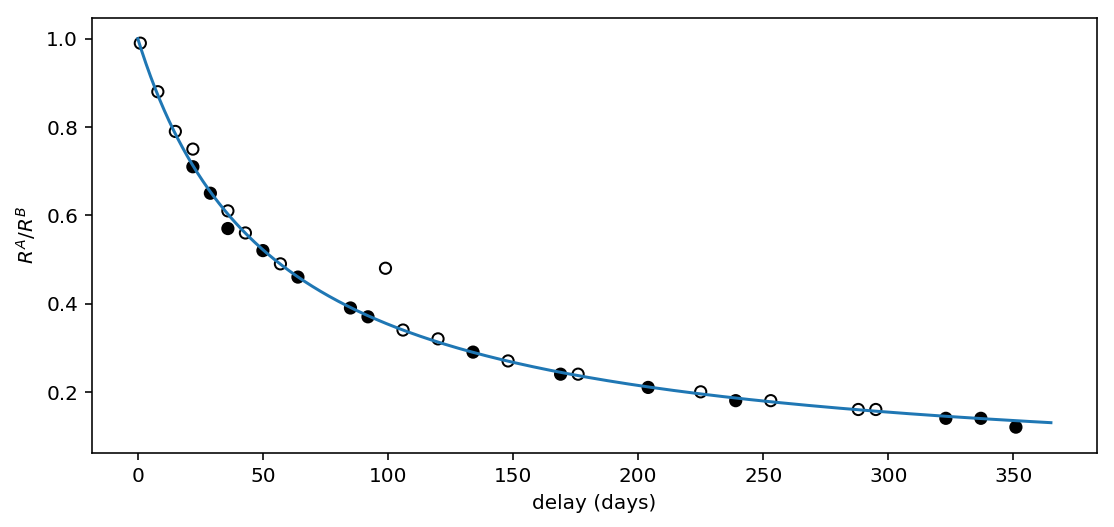

In [5]:
temp_model_to_fit = models.Hyperbolic(n_particles=10_000)

temp_D = DesignSpaceBuilder(RA=list(np.arange(5, 99+1, 1)), 
                            DB=list(np.arange(1, 365, 7))).build()
temp_design_thing = BayesianAdaptiveDesignGeneratorDARC(temp_D, 
                                                        max_trials=30)

temp_fitted_model, _ = simulated_experiment_trial_loop(temp_design_thing, 
                                                       temp_model_to_fit, 
                                                       response_model=response_model,
                                                       track_this_parameter=None)

data_plotter(temp_design_thing.get_df())

# append true indifference curve to the plot
delays = np.linspace(0, 365, 1000)
plt.plot(delays, hyperbolic_discount_func(delays, response_model.θ_true['logk'].values))

## Create a dataset of choices from that hyperbolic discounter

In [6]:
from darc.delayed.designs import Frye, DuGreenMyerson2002

In [7]:
heuristic_design_thing = DuGreenMyerson2002(DB=np.arange(1, 365, 7*4))

DRIFT_model_to_fit = models.DRIFT(n_particles=5_000)

fitted_DRIFT_model, _ = simulated_experiment_trial_loop(heuristic_design_thing, 
                                                  DRIFT_model_to_fit, 
                                                  response_model=response_model,
                                                  track_this_parameter=None)

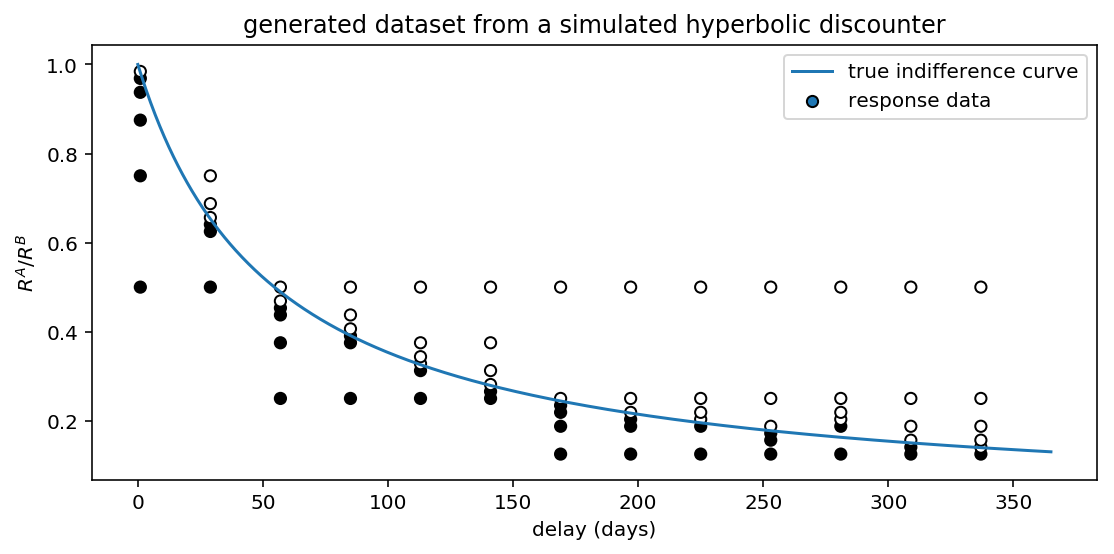

In [8]:
# get the simulated dataset
simulated_hyperbolic_dataset = heuristic_design_thing.get_df()

# plot it
data_plotter(simulated_hyperbolic_dataset)

# append true indifference curve to the plot
delays = np.linspace(0, 365, 1000)
plt.plot(delays, 
         hyperbolic_discount_func(delays, response_model.θ_true['logk'].values),
         label='true indifference curve')
plt.legend()
plt.title('generated dataset from a simulated hyperbolic discounter');

It is important to interpret this figure correctly...
It shows the responses of a hyperbolic discounter, running through the DuGreenMyerson2002 design protocol. The curve shows the true indifference curve. It is _nothing_ to do with the DRIFT model so far.

Let's look at the fitted parameters. With those, we will work out how the DRIFT model would have responded.

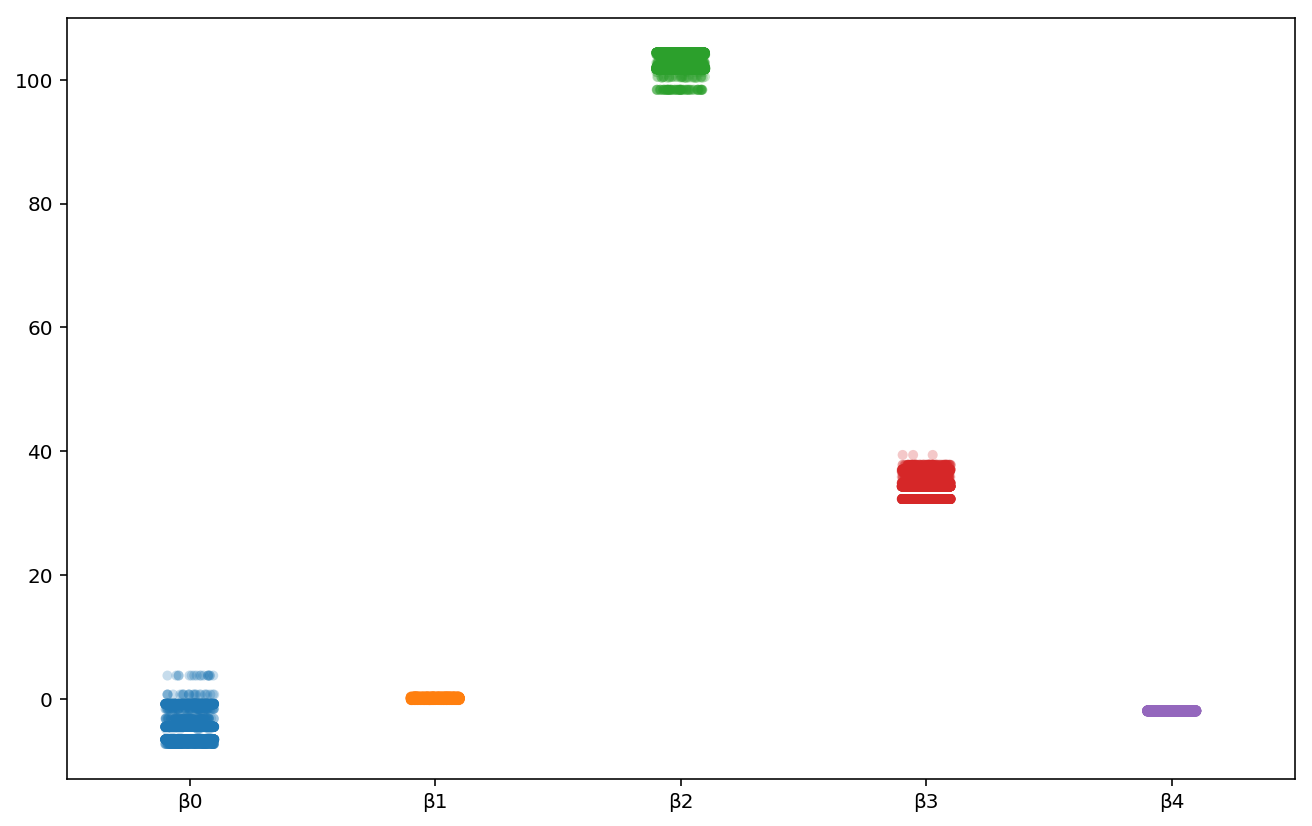

In [9]:
fig, ax = plt.subplots(figsize=(11, 7))

sns.stripplot(data=fitted_DRIFT_model.θ, alpha=.25, jitter=True, ax=ax);

😨 WE ARE GETTING PATHOLOGY IN THE POSTERIOR

Let's grab the median parameter values into a vector for use later

In [10]:
median_params = tuple(np.median(fitted_DRIFT_model.θ.values, axis=0))
median_params

(-4.50602762935853,
 0.20643529356735213,
 101.92687884363882,
 34.334491207804426,
 -1.92691001146101)

## Does the fitted DRIFT model produce hyperbolic-like choices

In [11]:
# TODO: generate response predictions to a set of designs. Also plot the true discounting 
# behaviour to see if the DRIFT model can get anywhere close to mirroring hyperbolic 
# discounting behaviour.

# get posterior predicted choices of fitted_DRIFT_model

# predicted_responses = fitted_DRIFT_model.simulate_y(probe_designs)

# Use the DARC Toolbox to estimate parameters of an DRIFT model
Again we assume an observer who actually discounts according to the hyperbolic discount function above. But we will use the DARC Toolbox to attemtp to select designs (near) optimally to estimate the parameters of the DRIFT model.

Create a DRIFT model which we will fit

In [12]:
model_to_fit = models.DRIFT(n_particles=50_000)

D = DesignSpaceBuilder(RA=list(np.arange(5, 99+1, 1)), 
                       DB=list(np.arange(1, 365, 7))).build()
design_thing = BayesianAdaptiveDesignGeneratorDARC(D, max_trials=40)

fitted_model, _ = simulated_experiment_trial_loop(design_thing, 
                                                  model_to_fit, 
                                                  response_model=response_model,
                                                  track_this_parameter=None)

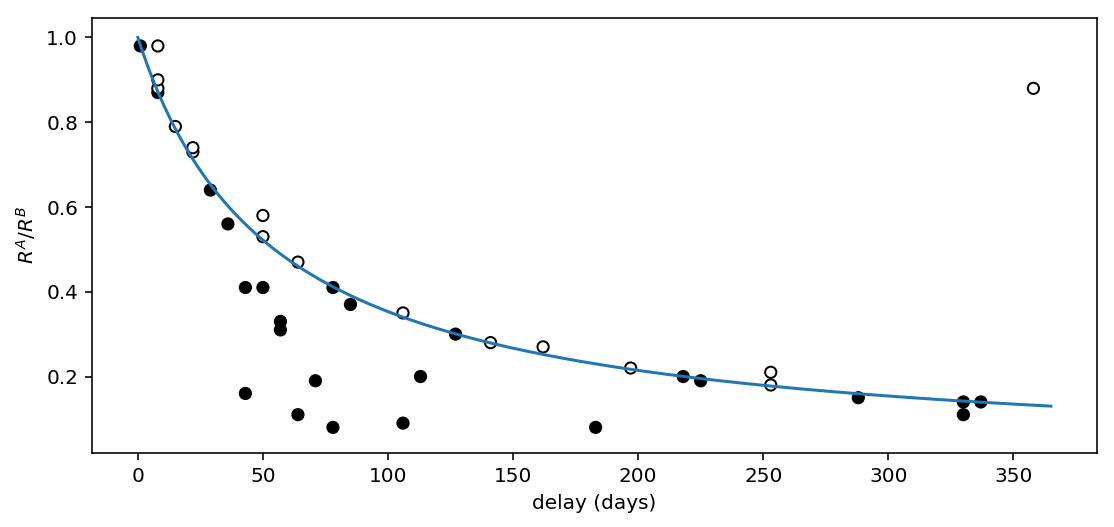

In [13]:
data_plotter(design_thing.get_df())

# append true indifference curve to the plot
delays = np.linspace(0, 365, 1000)
plt.plot(delays, hyperbolic_discount_func(delays, response_model.θ_true['logk'].values));

This is good. It looks like the DRIFT model _can_ produce behaviour which is hyperbolic like.

Let's visualise the posterior beliefs.

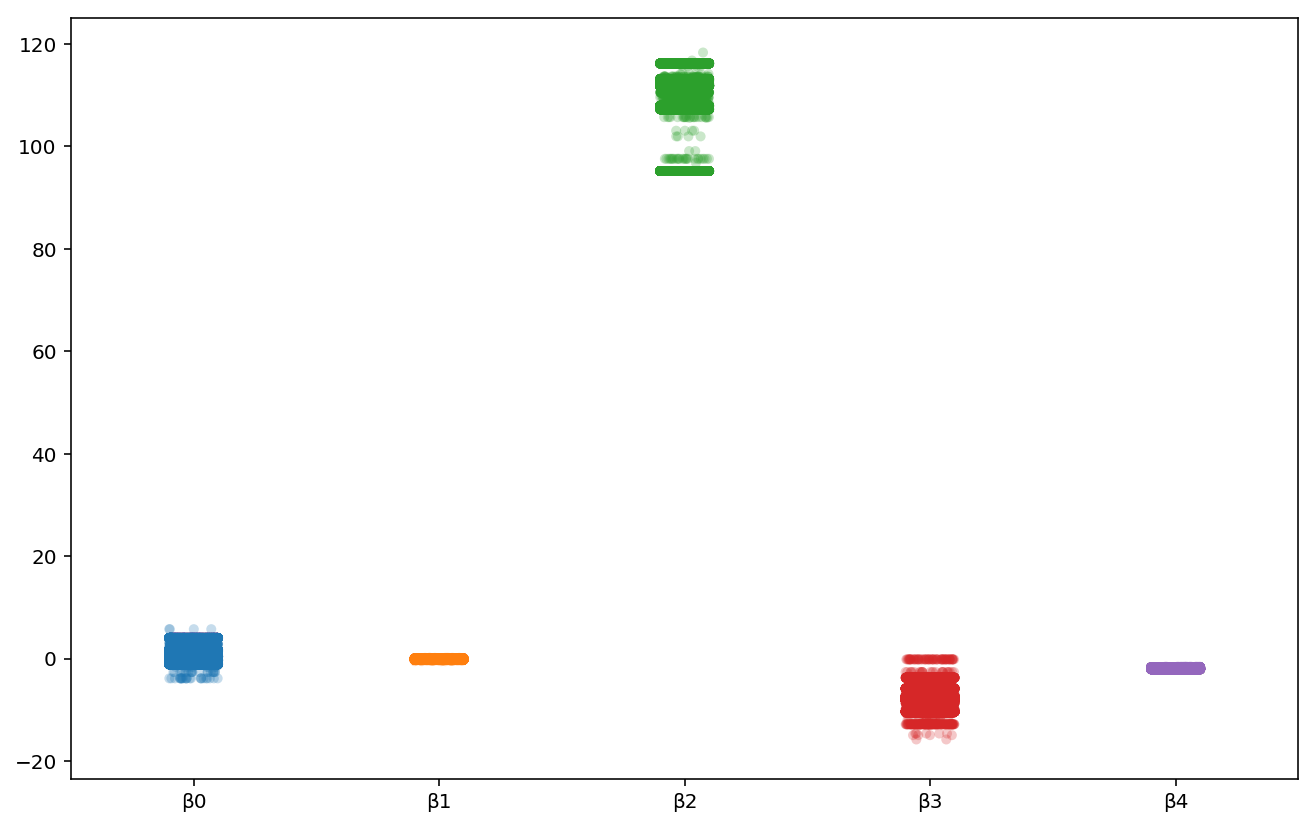

In [14]:
fig, ax = plt.subplots(figsize=(11, 7))

fitted_params = fitted_model.θ

sns.stripplot(data=fitted_params, alpha=.25, jitter=True, ax=ax);

😨 WE ARE GETTING SOME HORRIBLE PATHOLOGY IN THE PARTICLES

# Computing an indifference curve from the DRIFT model analytically
It should be possible to analytically calculate the indifference curve for a standard discounting type task. That is, if we set $x=0$ and solve for $RA$ and plot $RA/RB$ as a function of $DA$. This was we should be able to plot an indifference curve for our standard delay discounting design (no front end delay $DA=0$, fixed delayed reward $RB=£ 100$).

In [26]:
import sympy 

# pretty printing
sympy.init_printing()  

# define symbols
b0, b1, b2, b3, b4, RA, RB, DA, DB = sympy.symbols('b0 b1 b2 b3 b4 RA RB DA DB')

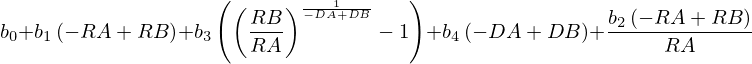

In [27]:
# define left and right hand sides of equation
LHS = 0  # setting x=0, which corresponds to indifference
RHS = (b0 
       + b1*(RB-RA) 
       + b2*((RB-RA)/RA )
       + b3*((RB/RA)**(1/(DB-DA)) - 1 )
       + b4*(DB-DA))

# visual check that we have specified the equation properly
RHS

Solve for the specific case we are interested in when x=0, RB=100, DA=0

In [28]:
# solve when RB=100, DA=0
LHS = 0
RHS = (b0 
       + b1*(100-RA) 
       + b2*((100-RA)/RA )
       + b3*((100/RA)**(1/(DB-0)) - 1 )
       + b4*(DB-0))
solution = sympy.solve(LHS-RHS, RA)
solution

NotImplementedError: multiple generators [(1/RA)**(1/DB), RA]
No algorithms are implemented to solve equation -DB*b4 - b0 - b1*(-RA + 100) - b3*((100/RA)**(1/DB) - 1) - b2*(-RA + 100)/RA

Hmmm, it seems that there is no analytical solution for an indifference curve in a basic temporal discounting task.

Can we find an analytical solution for an indifference _surface_ for the mangnitude effect?

In [30]:
# solve when DA=0
LHS = 0
RHS = (b0 
       + b1*(RB-RA) 
       + b2*((RB-RA)/RA )
       + b3*((RB/RA)**(1/(DB-0)) - 1 )
       + b4*(DB-0))
solution = sympy.solve(LHS-RHS, RA)
solution

NotImplementedError: multiple generators [(RB/RA)**(1/DB), RA]
No algorithms are implemented to solve equation -DB*b4 - b0 - b1*(-RA + RB) - b3*((RB/RA)**(1/DB) - 1) - b2*(-RA + RB)/RA

No. Also unable to calculate an indifference surface for the magnitude effect with no front end delay.

# References


Ericson, K. M. M., White, J. M., Laibson, D., & Cohen, J. D. (2015). Money earlier or later? Simple heuristics explain intertemporal choices better than delay discounting does. Psychological Science, 26(6), 826–833. http://doi.org/10.1177/0956797615572232

Read, D., Frederick, S., & Scholten, M. (2013). DRIFT: an analysis of outcome framing in intertemporal choice. Journal of Experimental Psychology: Learning, Memory, and Cognition, 39(2), 573–588. http://doi.org/10.1037/a0029177